# MXNet で CNN<br><small>Jupyter でライブ手書き文字認識</small>

<p style="text-align:center;font-size:150%;line-height:150%">2016/05/21 機械学習 名古屋 第4回勉強会<br>後藤 俊介 ( @antimon2 )</p>

## 自己紹介

+ 名前：後藤 俊介
+ 所属コミュニティ：**機械学習名古屋**（主催者の1人）、Python東海、Ruby東海
+ 言語：**Julia**, Python, Ruby, JavaScript, …
+ twitter: [@antimon2](https://twitter.com/antimon2 "あんちもん2(@antimon2)さん | Twitter")
+ Facebook: [antimon2](https://www.facebook.com/antimon2 "後藤 俊介")
+ GitHub: [antimon2](https://github.com/antimon2/ "antimon2 (GOTOH Shunsuke)")

※ 2016/06/01 から [有限会社来栖川電算](http://kurusugawa.jp/) に join します！

## MXNet とは？

+ [dmlc mxnet](https://github.com/dmlc/mxnet)（[MXNet.jl](https://github.com/dmlc/MXNet.jl)）
+ 2015/10 に出たばかりの新しいフレームワーク。
+ [Julia](http://julialang.org/), Python, R, Go, JavaScript などに対応した DeepLearning フレームワーク。
+ 記述の簡潔さと、（それに伴う）「効率」と「柔軟性」の両立。
+ 処理のコア部分は C(C++) で記述されている（それにより軽量性と多言語対応を実現している）。

※ 今回はデモのため、Julia での利用方法を示す。  
※ インストール等の詳細は今回は割愛。

## MXNet で CNN 構築

### 準備

In [1]:
using MXNet

### CNN構築1

入力〜2つの畳み込み層：

In [2]:
# input
data = mx.Variable(:data)

# first conv
conv1 = @mx.chain mx.Convolution(data=data, kernel=(5,5), num_filter=32)  =>
                  mx.Activation(act_type=:relu) =>
                  mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))

# second conv
conv2 = @mx.chain mx.Convolution(data=conv1, kernel=(5,5), num_filter=64) =>
                  mx.Activation(act_type=:relu) =>
                  mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007f941c0f58e0))

### CNN構築2

全結合層・ドロップアウト・出力層：

In [3]:
# first fully-connected
fc1   = @mx.chain mx.Flatten(data=conv2) =>
                  mx.FullyConnected(num_hidden=1024) =>
                  mx.Activation(act_type=:relu)

# dropout
dp_fc1 = mx.Dropout(fc1, p=0.5)

# second fully-connected
fc2   = mx.FullyConnected(data=dp_fc1, num_hidden=10)

# softmax loss
cnn = mx.SoftmaxOutput(data=fc2, name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007f941c3dc5b0))

### MNIST データ取得

In [4]:
# データ取得（データプロバイダ生成）
batch_size = 100
# include(Pkg.dir("MXNet", "examples", "mnist", "mnist-data.jl"))
# train_provider, eval_provider = get_mnist_providers(batch_size)
data_name = :data
label_name = :softmax_label
flat = false
train_provider = mx.MNISTProvider(image="MNIST_data/train-images-idx3-ubyte",
                                  label="MNIST_data/train-labels-idx1-ubyte",
                                  data_name=data_name, label_name=label_name,
                                  batch_size=batch_size, shuffle=true, flat=flat, silent=true)
eval_provider = mx.MNISTProvider(image="MNIST_data/t10k-images-idx3-ubyte",
                                 label="MNIST_data/t10k-labels-idx1-ubyte",
                                 data_name=data_name, label_name=label_name,
                                 batch_size=batch_size, shuffle=false, flat=flat, silent=true)


MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x00007f941c473e80),Tuple{Symbol,Tuple}[(:data,(28,28,1,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true)

### モデル構築・最適化（準備）

In [5]:
# モデル setup
model = mx.FeedForward(cnn, context=mx.cpu())

# optimization algorithm
optimizer = mx.SGD(lr=0.05, momentum=0.9, weight_decay=0.00001)

# save-checkpoint callback
save_checkpoint = mx.do_checkpoint("MNIST_CNN3")


MXNet.mx.EpochCallback(1,false,(anonymous function))

※ GPU が利用可能なら `context=mx.gpu(N)` のようにすることも可能。  
※ checkpoint とは、学習の経過（モデルとパラメータ）を随時（指定頻度で）保存する仕組み。後で利用。  
　※ ↑実運用的には、`mx.do_checkpoint()` に渡す引数（＝保存ファイルの prefix）は、日時等ユニークかつ管理しやすい名前にしましょう。

### 最適化（実施）

In [ ]:
# fit parameters
mx.fit(
    model,
    optimizer,
    train_provider,
    n_epoch=30,
    eval_data=eval_provider,
    callbacks=[save_checkpoint])

※ 非常に時間がかかります。

出力例：

![mx.fit 出力例](canvas_classify_sample_CNN_fit.png)

## チェックポイントの利用

### チェックポイントの読込

`MNIST_CNN3_TRAINED-symbol.json`、`MNIST_CNN3_TRAINED-0030.params` の2ファイルが作業ディレクトリに存在する前提で：

In [6]:
model = mx.load_checkpoint("MNIST_CNN3_TRAINED", 30, mx.FeedForward)

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007f941c656d10)),[CPU0],Dict(:fullyconnected0_weight=>mx.NDArray(1024,1024),:fullyconnected1_weight=>mx.NDArray(1024,10),:convolution0_bias=>mx.NDArray(32,),:convolution1_bias=>mx.NDArray(64,),:convolution0_weight=>mx.NDArray(5,5,1,32),:fullyconnected0_bias=>mx.NDArray(1024,),:convolution1_weight=>mx.NDArray(5,5,32,64),:fullyconnected1_bias=>mx.NDArray(10,)),Dict{Symbol,MXNet.mx.NDArray}(),#undef)

### 追加学習

In [ ]:
# optimization algorithm
optimizer = mx.SGD(lr=0.05, momentum=0.9, weight_decay=0.00001)

# save-checkpoint callback
save_checkpoint = mx.do_checkpoint("MNIST_CNN4")

# re-train
mx.fit(model, optimizer, train_provider, n_epoch=30, eval_data=eval_provider, callbacks=[save_checkpoint])

※ 全く同じ記述で学習の続きを実行可能（model のパラメータを再初期化したりはしない）。  
※ ただし `mx.do_checkpoint()` に渡す引数を変えないと、既存のチェックポイント保存ファイルを上書きしてしまうので注意！

### 学習済データを利用した推測

In [9]:
using PyPlot

In [7]:
batch = first(eval_provider)
idxs = rand(1:batch_size, 3)
images = copy(mx.get(eval_provider, batch, :data))[:,:,:,idxs]
provider = mx.ArrayDataProvider(images)
results = mx.predict(model, provider)

10x3 Array{Float32,2}:
 1.78033e-15  2.58459e-23  7.35042e-18
 1.64367e-8   1.17475e-18  1.143e-10  
 1.0          2.45633e-20  3.90283e-9 
 7.23107e-12  1.10644e-26  3.48953e-14
 2.97748e-12  1.0          5.08884e-12
 3.27321e-17  7.77427e-21  2.54193e-18
 1.67577e-11  1.50881e-22  1.88091e-19
 1.617e-12    1.22488e-22  1.0        
 1.77571e-16  1.55322e-21  3.70948e-18
 4.68788e-19  1.46468e-25  1.84964e-17

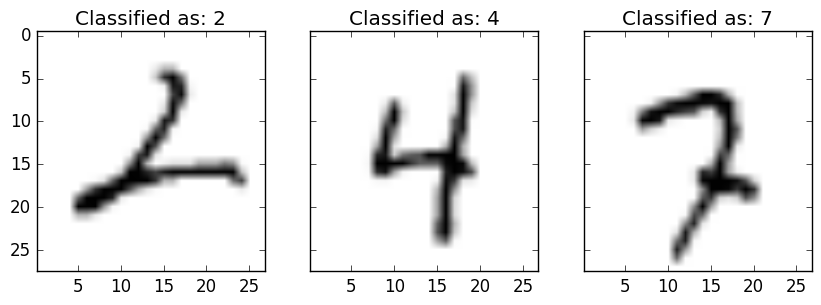

In [10]:
f, axs = PyPlot.subplots(1, 3, sharey=true, figsize=(10, 3))
for i = 1:3
    image = reshape(images[:,:,:,i], 28, 28)'
    axs[i][:imshow](image, cmap=get_cmap("Greys"))
    axs[i][:set_title]("Classified as: $(indmax(results[:,i])-1)")
end

## ライブ手書き数字認識

《デモ》

※ Jupyter の機能を利用して、学習済データによる推測と、canvas を利用した手書きデータの認識を実施。

実行例：

![ライブ手書き数字認識 実行例](canvas_classify_sample_CNN3_TRAINED_result.png)

## 参考

+ [dmlc mxnet](https://github.com/dmlc/mxnet)
+ [MXNet.jl](https://github.com/dmlc/MXNet.jl)
+ [The Julia Language](http://julialang.org/)（本家サイト、英語）
+ [Julia - josephmisiti/awesome-machine-learning](https://github.com/josephmisiti/awesome-machine-learning#julia-general-purpose)（Julia の機械学習関連ライブラリのリンクまとめ。英語）
+ [Project Jupyter](http://jupyter.org/)

ご清聴ありがとうございます。